# Books recommender systems

Recommender systems are surrounding us! Even if we don't see it, they are used on YouTube, Netflix, Spotify and much more popular portals and applications. 
The aim of this project is a review of basic recommender engines for books recommendations. Final project for Data Science bootcamp organized by Sages.

## Basic information about recommender systems

The most popular data that recommender systems are based on is users-to-items ratings. That type of data is called implicit - we know what user thinks about item directly.

<img src="photos/input_to_recommender.png" width="250">
Source : https://buildingrecommenders.wordpress.com/2015/11/23/overview-of-recommender-algorithms-part-5/

There are to 3 types of recommender systems : 
content based filtering, 
collaborative filtering and 
hybrid systyems. 

Content based filtering is based on analysis of products or users description. Each item and user is described by a set of features and the most simmilar products and users are choosen to be recommended. 

<img src="photos/content_based_filtering.png" width="850">
Source : https://buildingrecommenders.wordpress.com/2015/11/23/overview-of-recommender-algorithms-part-5/

Second type of recommender systems is collaborative filtering (CF). In this path two approaches should be mensioned : user-based CF and item-based CF. 

User-based CF takes user-to-item ratings and try to find users that rated items similarly to that specyfic user. Then takes the best rated items from group similar users. 

<img src="photos/user_based_collaborative_filtering.png" width="850">
Source : https://buildingrecommenders.wordpress.com/2015/11/23/overview-of-recommender-algorithms-part-5/

Item-based CF looks for items that are similar to the items that user has already rated and recommend most similar items.

<img src="photos/item_based_collaborative_filtering.png" width="850">
Source : https://buildingrecommenders.wordpress.com/2015/11/23/overview-of-recommender-algorithms-part-5/

Hybrid models use both collaborative filtering and content-based filtering at the same time to find the best predictions.

<img src="photos/hybrid_recommenders.png" width="850">
Source : https://buildingrecommenders.wordpress.com/2015/11/23/overview-of-recommender-algorithms-part-5/

## Dataset

There are not many books ratings datasets, but one of the most popular is [goodbooks-10k](https://www.kaggle.com/zygmunt/goodbooks-10k#book_tags.csv) [1] from [Kaggle](https://www.kaggle.com). This dataset cantains couple of tables, but I used two from it - books.csv and ratings.csv. 

Ratings.csv consists of UserId, BookId  and rating. There are 10000 unique books and total number of 981756 ratings. 

Books.csv contains book basic information like author, ISBN, release date, bookId and book  title. This table was jused just for finding specyfic books to compare recommentaions quality. 

## Technology stack

In project numerous libraries were used. It is worth mensioning libraries like **pandas,  numpy, sklearn, Keras** and some specyfic python recommendation libraries like **surprise** . 

### Imports 

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error
from keras.optimizers import Adam
from keras.layers import Input, Embedding, Flatten, merge, Dense, Activation, Dot, Concatenate, Dropout, BatchNormalization
from keras import Model
from keras.constraints import NonNeg
from keras.models import load_model, Sequential
from keras.callbacks import EarlyStopping
from keras.losses import mean_squared_error
import keras.backend as K
import random
import surprise
from surprise.model_selection.search import GridSearchCV
from surprise import SVDpp , NMF
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

### Dataset loading and train-test spliting

In [3]:
dataset = pd.read_csv('Dataset/ratings.csv')
books_dataset = pd.read_csv('Dataset/books.csv')

dataset = dataset.drop_duplicates(['user_id','book_id'])
train, test = train_test_split(dataset, test_size=0.2, random_state=111)

### Data info and  basic EDA

In [3]:
print ('Dataset info : \n')
print (dataset.info())
print ('\nDataset head : \n')
print (dataset.head())
print ('\nDataset columns : \n')
print (dataset.columns)
print ('\nDataset size : \n')
print (dataset.size)
print ('\nDataset ratings values : \n')
print (dataset.rating.value_counts().index)

Dataset info : 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979478 entries, 0 to 981755
Data columns (total 3 columns):
book_id    979478 non-null int64
user_id    979478 non-null int64
rating     979478 non-null int64
dtypes: int64(3)
memory usage: 29.9 MB
None

Dataset head : 

   book_id  user_id  rating
0        1      314       5
1        1      439       3
2        1      588       5
3        1     1169       4
4        1     1185       4

Dataset columns : 

Index(['book_id', 'user_id', 'rating'], dtype='object')

Dataset size : 

2938434

Dataset ratings values : 

Int64Index([4, 5, 3, 2, 1], dtype='int64')


##### Ratings number over ratings values

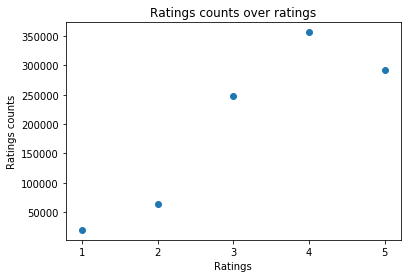

In [4]:
plt.scatter(dataset.rating.value_counts().index , dataset.rating.value_counts())
plt.title('Ratings counts over ratings')
plt.xticks(dataset.rating.value_counts().index)
plt.xlabel('Ratings')
plt.ylabel('Ratings counts')
plt.show()

#### Number of books in dataset and Number of users in dataset

In [5]:
print ("Number of unique users: {}".format(dataset.user_id.unique().size))
print ("Number of unique books: {}".format(dataset.book_id.unique().size))

Number of unique users: 53424
Number of unique books: 10000


##### Ratings basic information

In [6]:
print ("Ratings basic information: \n total ratings number - {}  \n ratings mean - {}  \n ratings std - {}".format(int(dataset.rating.describe()[0]),dataset.rating.describe()[1].round(2), dataset.rating.describe()[2].round(2) ))

Ratings basic information: 
 total ratings number - 979478  
 ratings mean - 3.86  
 ratings std - 0.98


##### Ratings values boxplot

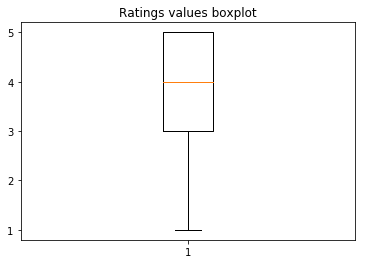

In [7]:
plt.boxplot(dataset.rating)
plt.title('Ratings values boxplot')
plt.yticks(dataset.rating.value_counts().index)
plt.show()

##### Ratings values mean per user

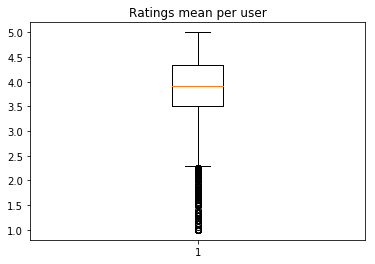

In [8]:
plt.boxplot(dataset.groupby('user_id').rating.mean())
plt.title('Ratings mean per user')
plt.show()

##### Number of rated books per user

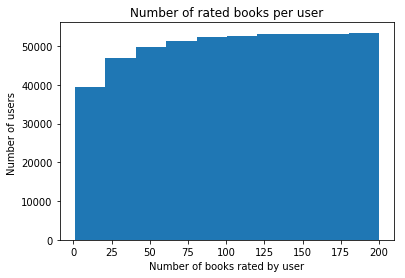

In [9]:
number_of_books_per_user = dataset.groupby('user_id').book_id.unique().apply(lambda x : len(x))

plt.hist(number_of_books_per_user, cumulative=True)
plt.title('Number of rated books per user')
plt.xlabel('Number of books rated by user')
plt.ylabel('Number of users ')
plt.show()

## KNN recommender - item-based (sklearn)

In [144]:
user_rating_pivot = dataset.pivot(index = 'book_id', columns = 'user_id', values = 'rating').fillna(0)
#user_rating_pivot = csr_matrix(user_rating_pivot.values)

model_knn = NearestNeighbors( n_neighbors=20 ,metric = 'cosine', algorithm = 'brute')
model_knn.fit(user_rating_pivot)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=20, p=2, radius=1.0)

In [145]:
def knn_item_recommender(book_index, n_recommendations=5):
    distances, indices = model_knn.kneighbors(user_rating_pivot.iloc[book_index, :].values.reshape(1, -1), n_neighbors=n_recommendations+1)

    for i in range(0, len(distances.flatten())):
        if i == 0:
            book_title = list(books_dataset[books_dataset['id'].isin([user_rating_pivot.index[book_index]])].original_title)[0]
            print('Recommendations for {0}:\n'.format(book_title))
        else:
            recommended_book_title = list(books_dataset[books_dataset['id'].isin([user_rating_pivot.index[indices.flatten()[i]]])].original_title)[0]
            print('{0}: {1}, with distance of {2}'.format(i, recommended_book_title, distances.flatten()[i]))

In [146]:
knn_item_recommender(1,10)

Recommendations for Harry Potter and the Philosopher's Stone:

1: To Kill a Mockingbird, with distance of 0.3892592020883805
2: Memoirs of a Geisha, with distance of 0.40241308954159594
3: Nineteen Eighty-Four, with distance of 0.4097614772716248
4: The Great Gatsby, with distance of 0.41205601974725015
5:  The Fellowship of the Ring, with distance of 0.4146445358053812
6: Lord of the Flies , with distance of 0.4159568738240007
7: Harry Potter and the Prisoner of Azkaban, with distance of 0.4226021355475864
8: The Hobbit or There and Back Again, with distance of 0.42733371842918766
9: Het Achterhuis: Dagboekbrieven 14 juni 1942 - 1 augustus 1944, with distance of 0.4317700868712365
10: Jane Eyre, with distance of 0.4402457989008367


## Matrix factorization - user - based collaborative filtering (surprise)

##### Preparing data for surprise library

In [ ]:
min_rating = train['rating'].min()
max_rating = train['rating'].max()
sr_reader = surprise.Reader(rating_scale=(min_rating, max_rating))
sr_data = surprise.Dataset.load_from_df(train, sr_reader)

##### Define SVD++ model and gridsearch

In [11]:
param_grid = {'n_factors': [ 10 , 15 , 20 ],
                'n_epochs': [ 10 , 20 ]
              }

svd_gs = GridSearchCV(SVDpp, 
                      param_grid, 
                      n_jobs=-1, 
                      cv = 3, 
                      refit= True, 
                      measures=['rmse', 'mae'], 
                      joblib_verbose= 1)

svd_gs.fit(sr_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed: 10.5min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 13.5min finished


##### Define NMF model and gridsearch

In [12]:
param_grid = {'n_factors': [ 10 , 15 , 20 ],
              'n_epochs': [ 10 , 20 ]
              }

nmf_gs = GridSearchCV(NMF, 
                      param_grid, 
                      n_jobs=-1, 
                      cv =3, 
                      refit= True, 
                      measures=['rmse', 'mae'], 
                      joblib_verbose= 1)

nmf_gs.fit(sr_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:  2.9min remaining:   50.4s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.9min finished


##### Define recommendations 

In [13]:
def surprise_recommendation(user_id, top_n):
    books_ids = train['book_id'].unique()
    user_books_ratings = train.loc[train['user_id']==user_id, 'book_id']
    no_rated_books_ids = np.setdiff1d(books_ids, user_books_ratings)
    
    svd_predictions = []
    nmf_predictions = []
    
    for no_rated_book_id in no_rated_books_ids:
        svd_predictions.append(svd_gs.predict(user_id, no_rated_book_id))
        nmf_predictions.append(nmf_gs.predict(user_id, no_rated_book_id))      
    
    svd_top_n_prediction_list = pd.Series([pred.est for pred in svd_predictions]).nlargest(top_n).index.values.tolist()
    nmf_top_n_prediction_list = pd.Series([pred.est for pred in nmf_predictions]).nlargest(top_n).index.values.tolist()
    
    svd_predictions = pd.DataFrame(svd_predictions)
    nmf_predictions = pd.DataFrame(nmf_predictions) 
    
    svd_result = list(zip(svd_top_n_prediction_list, svd_predictions.loc[svd_predictions['iid'].isin(svd_top_n_prediction_list)].est))
    nmf_result = list(zip(nmf_top_n_prediction_list, nmf_predictions.loc[nmf_predictions['iid'].isin(nmf_top_n_prediction_list)].est))
    
    for svd_id, svd_est in svd_result:
        svd_recommended_book_title = list(books_dataset[books_dataset['id'].isin([svd_id])].original_title)[0]
        print ('SVD recommendation is book: {} with estimated rating {}'.format(svd_recommended_book_title, np.round(svd_est,2)))
        
    for nmf_id, nmf_est in nmf_result:
        nmf_recommended_book_title = list(books_dataset[books_dataset['id'].isin([nmf_id])].original_title)[0]
        print ('NMF recommendation is book: {} with estimated rating {}'.format(nmf_recommended_book_title, np.round(nmf_est,2)))   

##### Get recommendations - given user id and number of needed recommendations

In [14]:
surprise_recommendation(50,5)

SVD recommendation is book: The Lucky One with estimated rating 4.07
SVD recommendation is book: The Hunt for Red October with estimated rating 3.94
SVD recommendation is book: Hopeless with estimated rating 4.47
SVD recommendation is book: Dreamcatcher with estimated rating 3.59
SVD recommendation is book: nan with estimated rating 3.97
NMF recommendation is book: Of Mice and Men  with estimated rating 4.3
NMF recommendation is book: The Time Traveler's Wife with estimated rating 3.98
NMF recommendation is book: Life of Pi with estimated rating 3.98
NMF recommendation is book: Brave New World with estimated rating 4.03
NMF recommendation is book: The Shining with estimated rating 3.38


## Matrix factorization with NonNegative values - user-based collaborative filtering (Keras)

#####  Building model

In [15]:
def build_mf_model(dataset = train, n_latent_factors = 5):
    n_users, n_books = len(dataset.user_id.unique()), len(dataset.book_id.unique())
    n_latent_factors = n_latent_factors

    book_input = Input(shape=[1],name='Book')
    book_embedding = Embedding(n_books + 1, n_latent_factors, name='Book-Embedding', embeddings_constraint=NonNeg())(book_input)
    book_vec = Flatten(name='FlattenBooks')(book_embedding)

    user_input = Input(shape=[1],name='User')
    user_embedding = Embedding(n_users + 1, n_latent_factors, name='User-Embedding', embeddings_constraint=NonNeg())(user_input)
    user_vec = Flatten(name='FlattenUsers')(user_embedding)

    prod = Dot(name='Dot_product',axes=1)([book_vec, user_vec])

    model = Model([user_input, book_input], prod)
    model_mf = model
    print(model.summary()) 
    return model_mf

In [16]:
def train_mf_models(n_latent_features_list=[3,5,7], optimizer='adam', loss= 'mean_squared_error', epochs=50):
    models_list = []
    errors_list = [np.inf]
    early_stopping = EarlyStopping(patience=5, monitor="val_mean_absolute_error")
    for n_latent_feature in n_latent_features_list:
        model = build_mf_model(dataset, n_latent_factors=n_latent_feature)
        model.compile(optimizer, 
                      loss,
                      metrics=['mse', 'mae'])
        
        history = model.fit([train.user_id, train.book_id], 
                            train.rating,
                            validation_data=([test.user_id,test.book_id],test.rating),
                            epochs=epochs,
                            callbacks=[early_stopping],
                            verbose=1)
        
        models_list.append(history)

        y_pred = np.round(model.predict([test.user_id, test.book_id]),0)
        y_true = test.rating
        error = mean_absolute_error(y_true, y_pred)
        
        if error < errors_list[-1]:
            model.save('best_model.h5')
        errors_list.append(error)

    best_mf_model = load_model('best_model.h5')
    
    return models_list, errors_list, best_mf_model

##### Define plots

In [30]:
def make_plots(models_list): 
    fig = plt.figure(figsize=(35,30))
    fig.subplots_adjust(hspace=0.4,wspace=0.2)    
    ax = fig.add_subplot(3, 2, 1)
    for model in models_list:
        ax.plot(model.history['loss'])
    ax.set_yscale('log')
    plt.title('Loss over epochs', fontsize=20)    
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Train loss', fontsize=16)
    plt.legend(['Model_1', "Model_2", "Model_3"], prop={'size': 20})
    
    ax = fig.add_subplot(3, 2, 2)  
    for model in models_list:
        ax.plot(model.history['val_loss'])
    ax.set_yscale('log')
    plt.title('Loss over epochs', fontsize=20)    
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Train loss', fontsize=16)
    plt.legend(['Model_1', "Model_2", "Model_3"], prop={'size': 20})

    
    ax = fig.add_subplot(3, 2, 3)
    for model in models_list:
        ax.plot(model.history['mean_squared_error'])
    ax.set_yscale('log')
    plt.title('MSE over epochs', fontsize=20)    
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('MSE', fontsize=16)
    plt.legend(['Model_1', "Model_2", "Model_3"], prop={'size': 20})
    
    ax = fig.add_subplot(3, 2, 4)
    for model in models_list:
        ax.plot(model.history['val_mean_squared_error'])
    ax.set_yscale('log')
    plt.title('Val_MSE over epochs', fontsize=20)    
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Val_MSE', fontsize=16)
    plt.legend(['Model_1', "Model_2", "Model_3"], prop={'size': 20})

    ax = fig.add_subplot(3, 2, 5)
    for model in models_list:
        ax.plot(model.history['mean_absolute_error'])
    ax.set_yscale('log')
    plt.title('MAE over epochs', fontsize=20)    
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('MAE', fontsize=16)
    plt.legend(['Model_1', "Model_2", "Model_3"], prop={'size': 20})
    
    ax = fig.add_subplot(3, 2, 6)
    for model in models_list:
        ax.plot(model.history['val_mean_absolute_error'])
    ax.set_yscale('log')
    plt.title('Val_MAE over epochs', fontsize=20)    
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Val_MAE', fontsize=16)
    plt.legend(['Model_1', "Model_2", "Model_3"], prop={'size': 20})
    
    plt.show()

In [18]:
def get_MAE(errors_list):
    for number, model in enumerate(errors_list[1:]):
            print( "Model {} MAE : {}".format(number+1, model))

##### Define recommendations

In [32]:
def keras_recommendation(best_model,user_id, number_of_recommendations):  
    total_recommenders=[]
    book_data = np.array(list(set(dataset.book_id)))
    user = np.array([user_id for i in range(len(book_data))])
    predictions = best_model.predict([user, book_data])
    predictions = np.array([a[0] for a in predictions])
    recommended_book_ids = (-predictions).argsort()[:number_of_recommendations]
    recommended_books_titles = books_dataset[books_dataset['id'].isin(recommended_book_ids)].original_title
    return recommended_books_titles

In [20]:
models_list, errors_list, best_mf_model = train_mf_models([3,5,7],
                                                    'adam', 
                                                    'mean_squared_error', 
                                                     epochs=50)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Book (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Book-Embedding (Embedding)      (None, 1, 3)         30003       Book[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         160275      User[0][0]                       
_____________________________________

Epoch 25/50
783582/783582 [==============================] - 65s 83us/step - loss: 0.6952 - mean_squared_error: 0.6952 - mean_absolute_error: 0.6343 - val_loss: 0.8220 - val_mean_squared_error: 0.8220 - val_mean_absolute_error: 0.6820
Epoch 26/50
783582/783582 [==============================] - 66s 84us/step - loss: 0.6940 - mean_squared_error: 0.6940 - mean_absolute_error: 0.6337 - val_loss: 0.8216 - val_mean_squared_error: 0.8216 - val_mean_absolute_error: 0.6812
Epoch 27/50
783582/783582 [==============================] - 66s 84us/step - loss: 0.6924 - mean_squared_error: 0.6924 - mean_absolute_error: 0.6326 - val_loss: 0.8215 - val_mean_squared_error: 0.8215 - val_mean_absolute_error: 0.6810
Epoch 28/50
783582/783582 [==============================] - 65s 83us/step - loss: 0.6910 - mean_squared_error: 0.6910 - mean_absolute_error: 0.6316 - val_loss: 0.8231 - val_mean_squared_error: 0.8231 - val_mean_absolute_error: 0.6810
Epoch 29/50
783582/783582 [==============================] -

Epoch 1/50
783582/783582 [==============================] - 152s 195us/step - loss: 8.3924 - mean_squared_error: 8.3924 - mean_absolute_error: 2.4981 - val_loss: 2.8246 - val_mean_squared_error: 2.8246 - val_mean_absolute_error: 1.2651
Epoch 2/50
783582/783582 [==============================] - 151s 192us/step - loss: 1.8074 - mean_squared_error: 1.8074 - mean_absolute_error: 0.9949 - val_loss: 1.5156 - val_mean_squared_error: 1.5156 - val_mean_absolute_error: 0.9037
Epoch 3/50
783582/783582 [==============================] - 152s 194us/step - loss: 1.1453 - mean_squared_error: 1.1453 - mean_absolute_error: 0.8036 - val_loss: 1.2079 - val_mean_squared_error: 1.2079 - val_mean_absolute_error: 0.8119
Epoch 4/50
783582/783582 [==============================] - 152s 194us/step - loss: 0.9409 - mean_squared_error: 0.9409 - mean_absolute_error: 0.7372 - val_loss: 1.0735 - val_mean_squared_error: 1.0735 - val_mean_absolute_error: 0.7713
Epoch 5/50
783582/783582 [==============================

##### Train loss, train MSE , train MAE , Validation loss, validation MSE, validation MAE plots

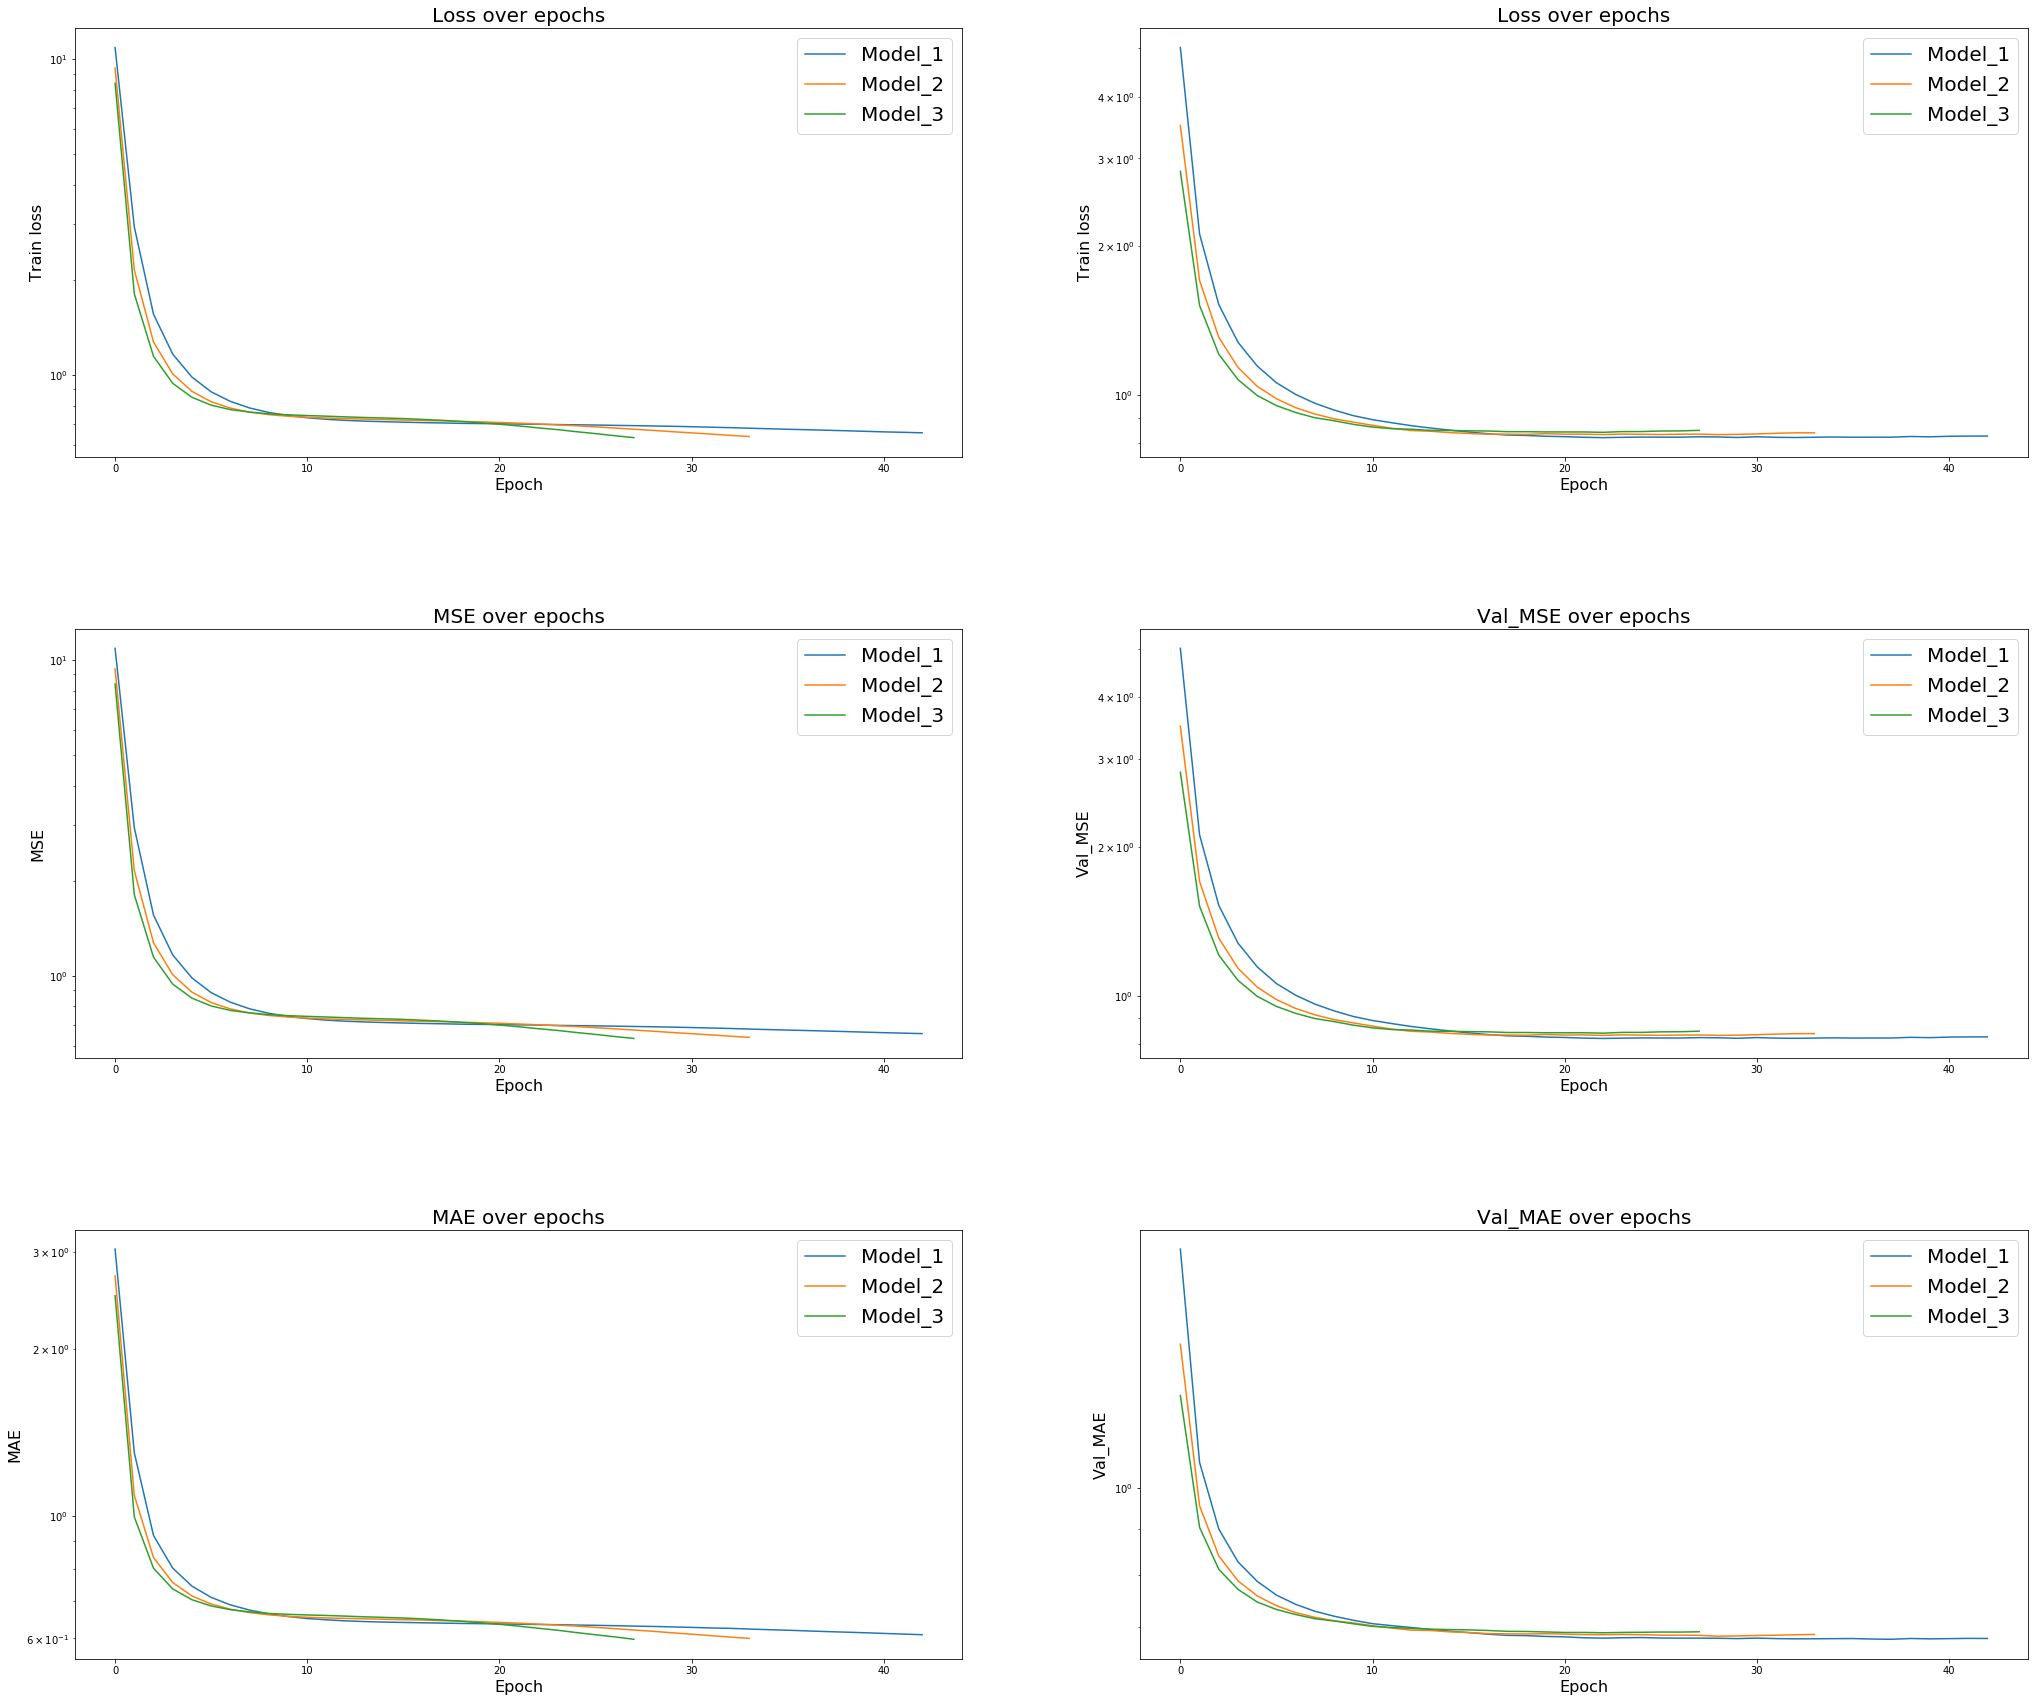

In [21]:
make_plots(models_list)

##### Get x number ofrecommendations for user_id

In [22]:
keras_recommendation(best_mf_model, user_id=8, number_of_recommendations=10)

3091             You Shall Know Our Velocity!
5988            Princess of the Midnight Ball
6087                Mrs. Lincoln's Dressmaker
7829                               Shock Wave
8207    Drink Deep (Chicagoland Vampires, #5)
8614                       Celebrity in Death
8944                        The Next Accident
9037                               Candy Girl
9568                          The Hate U Give
9965              The Ground Beneath Her Feet
Name: original_title, dtype: object

## Neural Collaborative Filtering - user-based (Keras)

According to [paper](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf)

In [52]:
def build_ncf_model(dataset = train, n_latent_factors_user = 6, n_latent_factors_book=7, n_latent_factors_mf=3):
    
    n_latent_factors_user = n_latent_factors_user
    n_latent_factors_book = n_latent_factors_book
    n_latent_factors_mf = n_latent_factors_mf
    
    n_users, n_books = len(dataset.user_id.unique()), len(dataset.book_id.unique())

    book_input = Input(shape=[1],name='Item')
    book_embedding_mlp = Embedding(n_books + 1, n_latent_factors_book, name='Book-Embedding-MLP')(book_input)
    book_vec_mlp = Flatten(name='FlattenBooks-MLP')(book_embedding_mlp)
    book_vec_mlp = Dropout(0.2,name='Dropout-B_MLP')(book_vec_mlp)

    book_embedding_mf = Embedding(n_books + 1, n_latent_factors_mf, name='Book-Embedding-MF')(book_input)
    book_vec_mf = Flatten(name='FlattenBook-MF')(book_embedding_mf)
    book_vec_mf = Dropout(0.2,name='Dropout-B_MF')(book_vec_mf)


    user_input = Input(shape=[1],name='User')
    user_embedding_mlp = Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding-MLP')(user_input)
    user_vec_mlp = Flatten(name='FlattenUsers-MLP')(user_embedding_mlp)
    user_vec_mlp = Dropout(0.2,name='Dropout-U_MLP')(user_vec_mlp)

    user_embedding_mf = Embedding(n_users + 1, n_latent_factors_mf,name='User-Embedding-MF')(user_input)
    user_vec_mf = Flatten(name='FlattenUsers-MF')(user_embedding_mf)
    user_vec_mf = Dropout(0.2,name='Dropout-U_MF')(user_vec_mf)


    concat = Concatenate(axis=1, name='Concat')([book_vec_mlp, user_vec_mlp])
    concat_dropout = Dropout(0.2)(concat)
    dense = Dense(200,name='FullyConnected')(concat_dropout)
    dense_batch = BatchNormalization(name='Batch')(dense)
    dropout_1 = Dropout(0.2,name='Dropout-1')(dense_batch)
    dense_2 = Dense(100,name='FullyConnected-1')(dropout_1)
    dense_batch_2 = BatchNormalization(name='Batch-2')(dense_2)


    dropout_2 = Dropout(0.2,name='Dropout-2')(dense_batch_2)
    dense_3 = Dense(50,name='FullyConnected-2')(dropout_2)
    dense_4 = Dense(20,name='FullyConnected-3', activation='relu')(dense_3)

    pred_mf = Dot( axes=1,  name='Dot')([book_vec_mf, user_vec_mf])
    pred_mlp = Dense(1, activation='relu',name='Activation')(dense_4)

    combine_mlp_mf = Concatenate(axis=1, name='Concat-MF-MLP')([pred_mf, pred_mlp])
    result_combine = Dense(100,name='Combine-MF-MLP')(combine_mlp_mf)
    deep_combine = Dense(100,name='FullyConnected-4')(result_combine)


    result = Dense(1,name='Prediction')(deep_combine)


    model = Model([user_input, book_input], result)
    opt = Adam(lr =0.01)
    model.compile(optimizer='adam',loss= 'mean_absolute_error')
    print (model.summary())
    return model

In [53]:
def train_nfc_models(n_latent_features_list=[3,5,7], optimizer='adam', loss= 'mean_squared_error', epochs=2):
    
    nfc_models_list = []
    nfc_errors_list = [np.inf]
    early_stopping = EarlyStopping(patience=5, monitor="val_mean_absolute_error")
    
    for n_latent_feature in n_latent_features_list:
        model = build_ncf_model(dataset, n_latent_factors_mf=n_latent_feature)
        model.compile(optimizer, 
                      loss,
                      metrics=['mse', 'mae'])
        
        history = model.fit([train.user_id, train.book_id], 
                            train.rating,
                            validation_data=([test.user_id,test.book_id],test.rating),
                            epochs=epochs,
                            callbacks=[early_stopping],
                            verbose=1)
        
        nfc_models_list.append(history)

        y_pred = np.round(model.predict([test.user_id, test.book_id]),0)
        y_true = test.rating
        error = mean_absolute_error(y_true, y_pred)
        
        if error < nfc_errors_list[-1]:
            model.save('best_nfc_model.h5')
        nfc_errors_list.append(error)

    best_nfc_model = load_model('best_nfc_model.h5')
    
    return nfc_models_list, nfc_errors_list, best_nfc_model

In [54]:
nfc_models_list, nfc_errors_list, best_nfc_model = train_nfc_models([3,5,7],
                                                    'adam', 
                                                    'mean_squared_error', 
                                                     epochs=50)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Book-Embedding-MLP (Embedding)  (None, 1, 7)         70007       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding-MLP (Embedding)  (None, 1, 6)         320550      User[0][0]                       
__________________________________________________________________________________________________
FlattenBoo

783582/783582 [==============================] - 253s 323us/step - loss: 0.8007 - mean_squared_error: 0.8007 - mean_absolute_error: 0.6982 - val_loss: 0.8596 - val_mean_squared_error: 0.8596 - val_mean_absolute_error: 0.7187
Epoch 8/50
783582/783582 [==============================] - 253s 323us/step - loss: 0.7849 - mean_squared_error: 0.7849 - mean_absolute_error: 0.6893 - val_loss: 0.8398 - val_mean_squared_error: 0.8398 - val_mean_absolute_error: 0.7198
Epoch 9/50
783582/783582 [==============================] - 253s 323us/step - loss: 0.7742 - mean_squared_error: 0.7742 - mean_absolute_error: 0.6829 - val_loss: 0.8320 - val_mean_squared_error: 0.8320 - val_mean_absolute_error: 0.7234
Epoch 10/50
783582/783582 [==============================] - 254s 324us/step - loss: 0.7642 - mean_squared_error: 0.7642 - mean_absolute_error: 0.6774 - val_loss: 0.8260 - val_mean_squared_error: 0.8260 - val_mean_absolute_error: 0.7103
Epoch 11/50
783582/783582 [==============================] - 253s 

Train on 783582 samples, validate on 195896 samples
Epoch 1/50
783582/783582 [==============================] - 292s 372us/step - loss: 0.9839 - mean_squared_error: 0.9839 - mean_absolute_error: 0.7911 - val_loss: 0.9881 - val_mean_squared_error: 0.9881 - val_mean_absolute_error: 0.7429
Epoch 2/50
783582/783582 [==============================] - 287s 367us/step - loss: 0.9724 - mean_squared_error: 0.9724 - mean_absolute_error: 0.7874 - val_loss: 0.9712 - val_mean_squared_error: 0.9712 - val_mean_absolute_error: 0.8021
Epoch 3/50
783582/783582 [==============================] - 289s 369us/step - loss: 0.9712 - mean_squared_error: 0.9712 - mean_absolute_error: 0.7871 - val_loss: 0.9692 - val_mean_squared_error: 0.9692 - val_mean_absolute_error: 0.7888
Epoch 4/50
783582/783582 [==============================] - 289s 369us/step - loss: 0.9708 - mean_squared_error: 0.9708 - mean_absolute_error: 0.7869 - val_loss: 0.9696 - val_mean_squared_error: 0.9696 - val_mean_absolute_error: 0.7951
Epoc

783582/783582 [==============================] - 330s 421us/step - loss: 0.9914 - mean_squared_error: 0.9914 - mean_absolute_error: 0.7928 - val_loss: 0.9684 - val_mean_squared_error: 0.9684 - val_mean_absolute_error: 0.7746
Epoch 2/50
783582/783582 [==============================] - 329s 420us/step - loss: 0.9215 - mean_squared_error: 0.9215 - mean_absolute_error: 0.7641 - val_loss: 0.9181 - val_mean_squared_error: 0.9181 - val_mean_absolute_error: 0.7487
Epoch 3/50
783582/783582 [==============================] - 330s 422us/step - loss: 0.8175 - mean_squared_error: 0.8175 - mean_absolute_error: 0.7099 - val_loss: 0.8796 - val_mean_squared_error: 0.8796 - val_mean_absolute_error: 0.7284
Epoch 4/50
783582/783582 [==============================] - 331s 422us/step - loss: 0.7551 - mean_squared_error: 0.7551 - mean_absolute_error: 0.6753 - val_loss: 0.8474 - val_mean_squared_error: 0.8474 - val_mean_absolute_error: 0.7216
Epoch 5/50
783582/783582 [==============================] - 330s 42

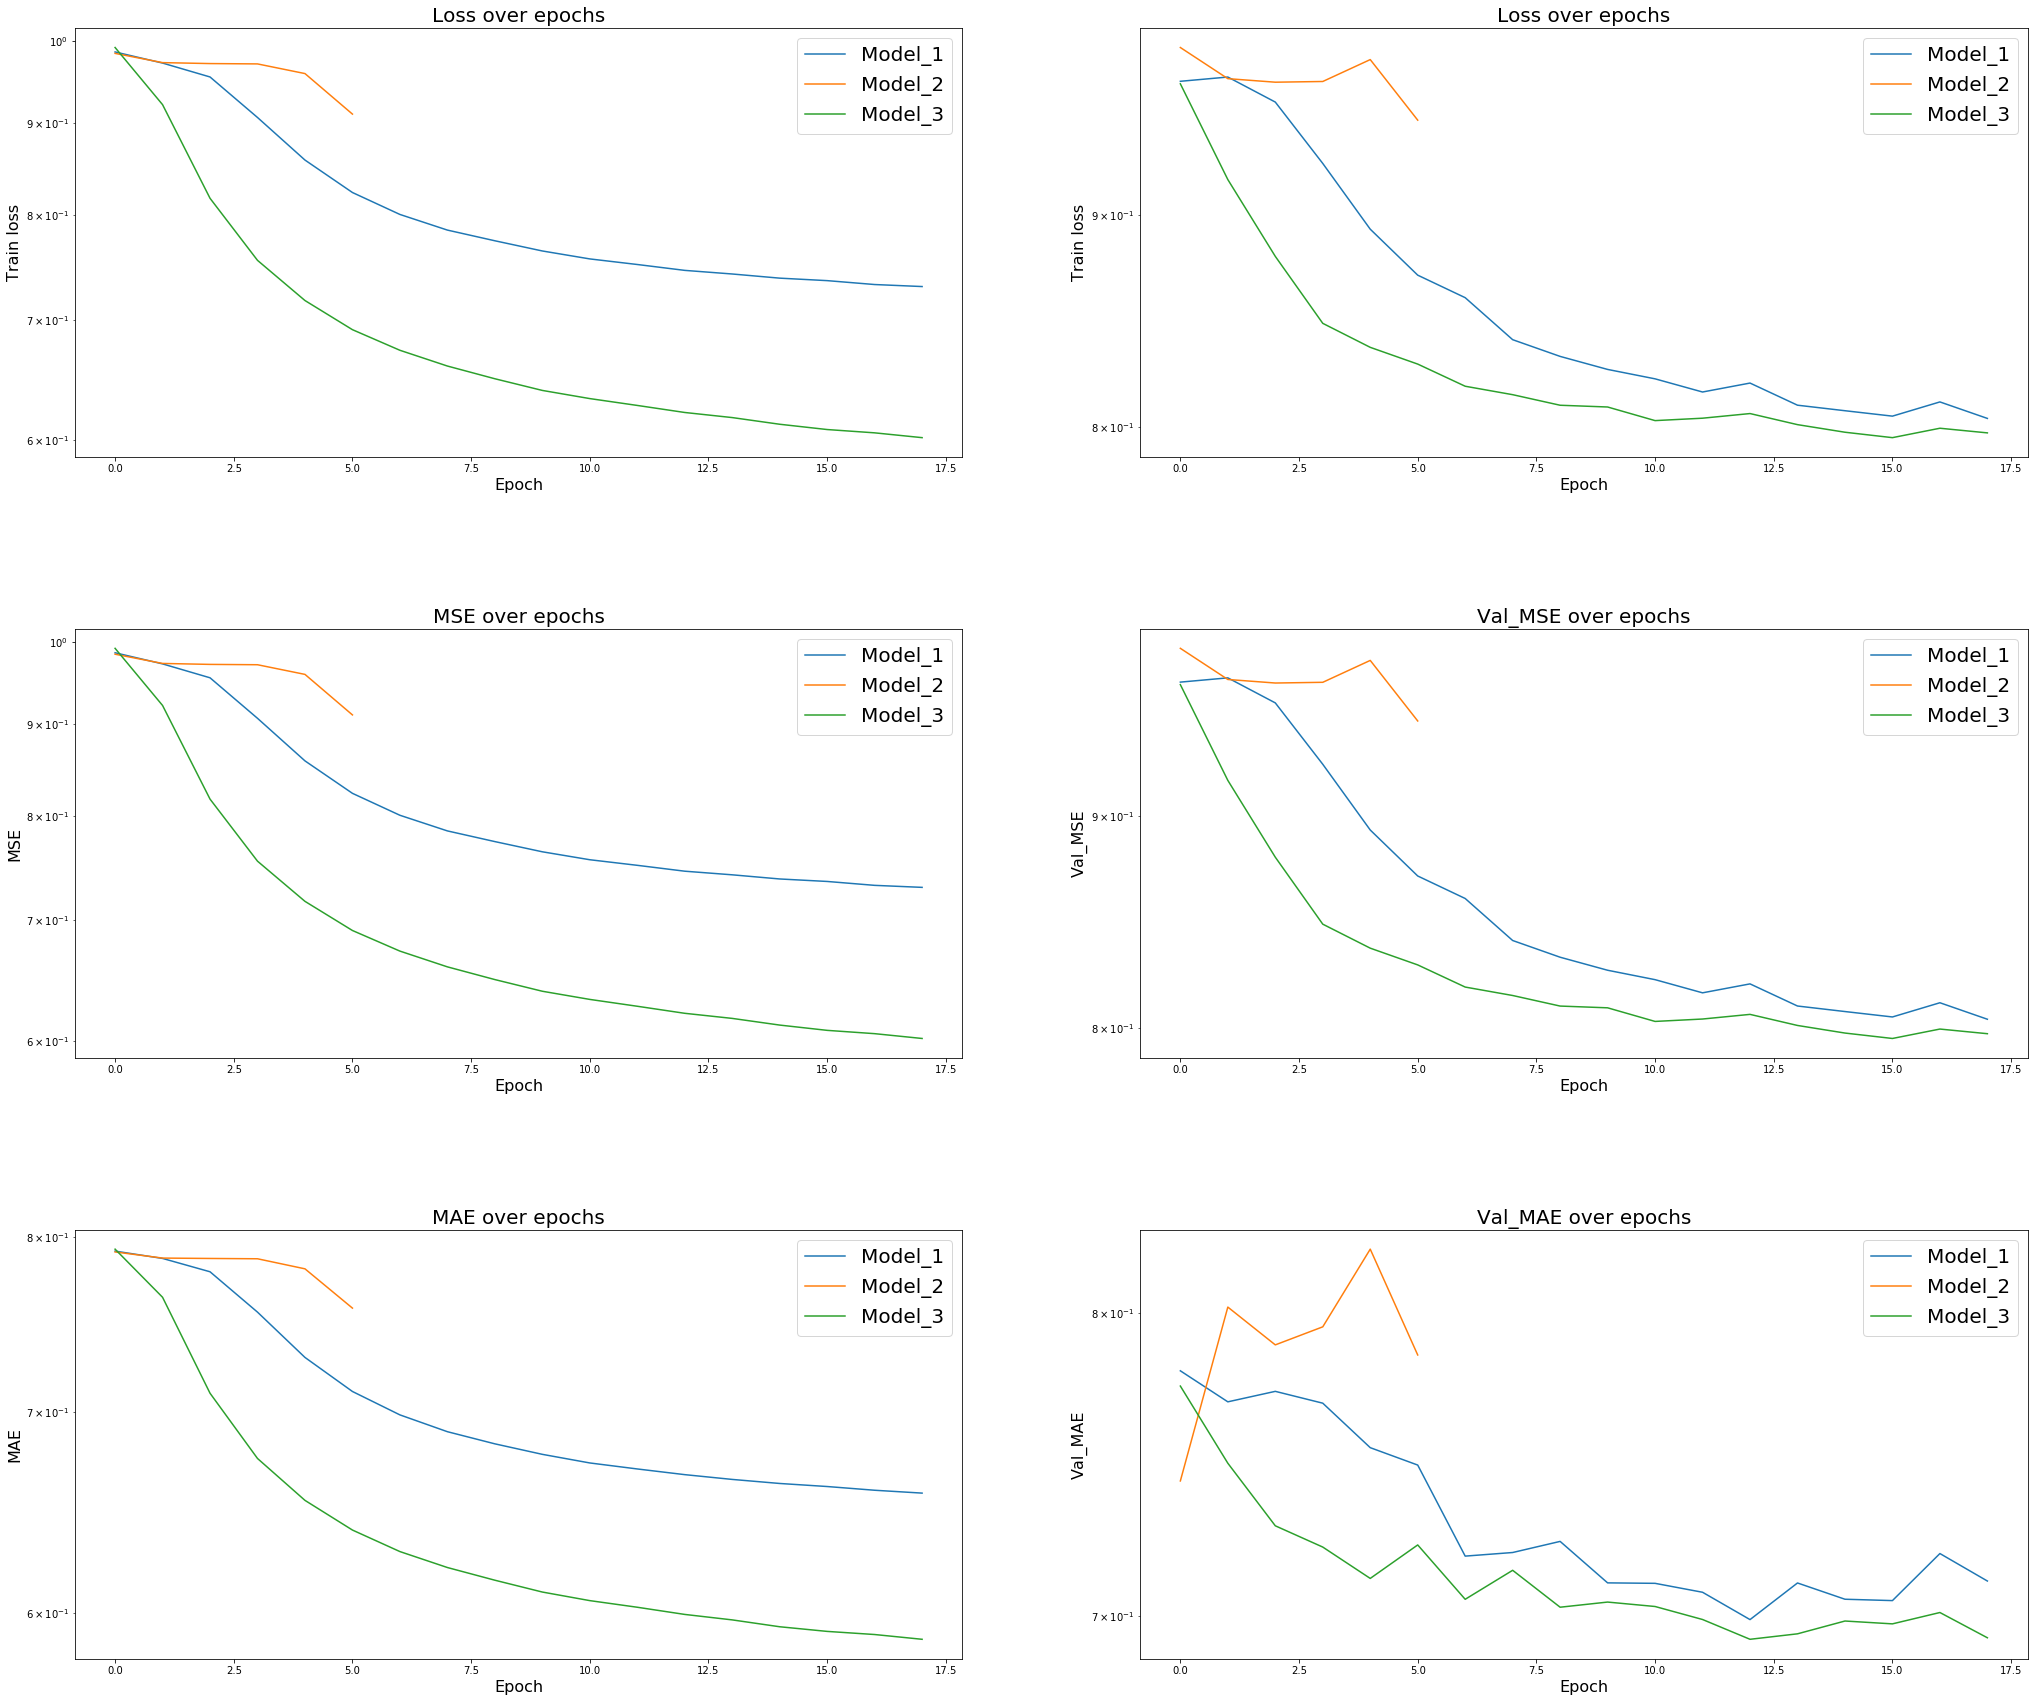

In [55]:
make_plots(nfc_models_list)

In [56]:
keras_recommendation(best_nfc_model, user_id=8, number_of_recommendations=10)

4934                        28 حرف
6140                           NaN
6937           Running Out of Time
7438                    Revelation
8324            A Work in Progress
8531          Memorial do Convento
8587                 City of Glass
8875                    Angelology
9688         A Death in the Family
9777    Captain Blood: His Odyssey
Name: original_title, dtype: object